In [1]:
import os
import json
import h5py
import pickle as pkl
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader

import models
from denseloader3m import YFCC_3M
from deneval_utils3m import language_eval

device = torch.device("cuda")

with open("data/vocabulary.pkl", "rb") as file:
    w2i = pkl.load(file)

vocab = {k+1:i for i, k in w2i.items()}
data = json.load(open("data/personcap_added1.json"))["images"][-9000:]
p2p = json.load(open("data/personalised_captions/i2w_personality_mapping.json"))

opt = {"vocab_size": 10451, "seq_length": 16, "seq_per_img": 1, "caption_model": "densepembed",
       "vocab": vocab, "beam_size": 4, 
       "att_feat_size": 2048, "batch_size": 32, "input_encoding_size" : 1024, "fc_feat_size": 2048, 
       "rnn_size": 2048, "att_hid_size": 512, "num_layers": 2, "drop_prob_lm": 0.5, 
       "start_from": "best_model/adaptive_scst_wg_model", #"log_added_new1/log_densepembed2_added",
       "metadata_json": "data/personalised_captions/i2w_personality_mapping.json",
       "input_fc_dir": "data/yfcc_images/resnext101_32x48d_wsl", 
       "input_att_dir": "data/yfcc_images/resnext101_32x48d_wsl_spatial_att",
       "input_json": "data/personalised_captions/testing_ids.json", 
       "input_label_h5": "data/personalised_cap_labels/testing_labels.npy",
       "input_label_start_idx": "data/personalised_cap_labels/testing_start_ix.npy", 
       "input_label_end_idx": "data/personalised_cap_labels/testing_end_ix.npy",
       "perss_onehot_h5": "data/personalities_onehot/testing.npy", 
       "densecap_dir": "data/dense_captions/testing.npy"}

In [ ]:
with open("data/running_avg_rewards.pkl","rb") as f:
    file = pkl.load(f)

In [ ]:
avg = []
for i in range(len(file)):
    avg.append(np.mean(file[i]))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(avg[0:-1:50])

In [2]:
class AttrDict(dict):
    def __getattr__(self, attr):
        if attr in self:
            return self[attr]
        else:
            raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{attr}'")
            
vals = AttrDict(opt)

In [3]:
test_ds = YFCC_3M(vals)

vocab size is  10451
personality size is  216
loading json files:  data/yfcc_images/resnext101_32x48d_wsl data/yfcc_images/resnext101_32x48d_wsl_spatial_att data/personalised_cap_labels/testing_labels.npy


In [4]:
test_ds[0][0].shape, test_ds[0][1].shape, test_ds[0][2].shape, test_ds[0][3].shape, test_ds[0][4].shape, test_ds[0][5].shape, test_ds[0][6].shape

(torch.Size([2048, 1, 1]),
 torch.Size([49, 2048]),
 torch.Size([5, 16]),
 torch.Size([18]),
 torch.Size([5, 16]),
 torch.Size([18]),
 torch.Size([217]))

In [5]:
test_loader = DataLoader(test_ds, batch_size=vals.batch_size, shuffle=False, 
                         num_workers=24, pin_memory=True, drop_last=True)

In [6]:
# for i, (a, b, c, d, e, f, g, h, i) in enumerate(test_loader):
#     print(a.shape, b.shape, c.shape)

In [7]:
model_path = os.path.join(vals.start_from, 'model-best' + '.pth')
model = models.setup(vals).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [ ]:
file = pkl.load(open("log_added_new1/log_densepembed2_added/infos_densepembed2_added-best.pkl", "rb"))
# file["epoch"] = 11
file.keys(), file["epoch"], file["best_val_score"], file["iter"], len(file["personality"])
# file.keys(), file['val_result_history']

In [ ]:
# start = np.arange(1, 49897, 5)
# end = np.arange(5, 49901, 5)

# with open(f"data/personalised_cap_labels/testing_start_ix.npy", "wb") as f:
#     np.save(f, start)

In [ ]:
# import random

# def get_captions(ix, seq_per_img):
#     # fetch the sequence labels
#     ix1 =  label_start_ix[ix] - 1 #label_start_ix starts from 1
#     ix2 =  label_end_ix[ix] - 1
#     ncap = ix2 - ix1 + 1 # number of captions available for this image
#     assert ncap > 0, 'an image does not have any label. this can be handled but right now isn\'t'

#     if ncap < seq_per_img:
#         # we need to subsample (with replacement)
#         seq = np.zeros([seq_per_img, seq_length], dtype = 'int')
#         for q in range(seq_per_img):
#             ixl = random.randint(ix1,ix2)
#             seq[q, :] = label[ixl, :seq_length]
#     else:
#         ixl = random.randint(ix1, ix2 - seq_per_img + 1)
#         seq = label[ixl: ixl + seq_per_img, :seq_length]

#     return seq

# label = np.load(opt["input_label_h5"]) 
# seq_size = label.shape
# seq_length = seq_size[1]
# label_start_ix = np.load(opt["input_label_start_idx"]) 
# label_end_ix = np.load(opt["input_label_end_idx"]) 

In [ ]:
# h5_label_file = h5py.File("data/personcap_added1_label.h5", 'r', driver='core')

# label_end_ix = h5_label_file["label_end_ix"]
# label_start_ix = h5_label_file["label_start_ix"]
# end = label_end_ix[186699:191691]
# start = label_start_ix[186699:191691]
# test = label_end_ix [191692:]

# with open(f"data/personalised_cap_labels/test_end_ix.npy", "wb") as f:
#     np.save(f, test)

In [ ]:
# densecap = h5py.File("data/densecap_added1.h5", 'r', driver='core')

# train = densecap["dense_cap"][:186698]
# val = densecap["dense_cap"][186699:191691]
# test = densecap["dense_cap"][-9998:]

# with open(f"data/dense_captions/testing.npy", "wb") as f:
#     np.save(f, test)

In [ ]:
# onehot = h5py.File("data/person_onehot_added1.h5", 'r', driver='core')

# train = onehot["perss_onehot"][:186698]
# val = onehot["perss_onehot"][186699:191691]
# test = onehot["perss_onehot"][-9998:]

# with open(f"data/personalities_onehot/testing.npy", "wb") as f:
#     np.save(f, test)

In [ ]:
# person_cap = json.load(open("data/personcap_added1.json"))

# train = person_cap["images"][:186698]
# val = person_cap["images"][186699:191691]
# test = person_cap["images"][-9998:]

# json.dump(test, open("data/personalised_captions/testing_ids.json", 'w'))

In [ ]:
# !pip install lmdb

## Inference 

In [ ]:
# image_name = "ParlAI/images/val_images/07610e564b3ca73b6df7bffa33ea62.jpg"
# Image.open(f"../{image_name}")

# fivecaps = img_cap["07610e564b3ca73b6df7bffa33ea62"]["captions"][:5]

# import re
# RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)

# Ci = np.zeros((5, 16), dtype='uint32')
# for j,s in enumerate(fivecaps):
#     txt= RETOK.findall(s)
#     for k,w in enumerate(txt):
#         if k < 16:
#             Ci[j,k] = w2i.get(w, w2i['UNK']) +1
            
# for i in range(4992):
#     if data[i]["file_path"] == image_name:
#         print(i)
#         print(data[i]["sentence"])
#         print(data[i]["personality"])
#         print(data[i]["file_path"])

In [8]:
def inference(index, trait_index):
    img_hash = test_ds[index][-1]["id"]
    ofc_feats = test_ds[index][0].to(device)
    oatt_feats = test_ds[index][1].unsqueeze(0).to(device)
    dcap = test_ds[index][2]
    dcap = torch.from_numpy(np.int32(dcap)).to(device).unsqueeze(0)
    attention_mask =  torch.ones(1, 80//vals.beam_size)
    traits = torch.nn.functional.one_hot(torch.arange(0, 217), num_classes=217)[trait_index].unsqueeze(0).to(device)

    pred, _= model._sample_beam(ofc_feats, oatt_feats, dcap, attention_mask, personality=traits, opt={"beam_size":vals.beam_size,
                                                                                                     "temperature": 1.4})

    pred = pred.detach().cpu().numpy().tolist()

    ids = traits.detach().cpu().numpy()
    personality_index = np.where(ids==1)[1][0]
    personality = p2p["pix_to_personality"][str(personality_index)]
    g_personality = test_ds[index][-1]["personality"]

    cap = ""
    for i in pred[0]:
        if i != 0:
            cap = cap + " " + vocab[i]
    return personality, cap

4985
Generated Caption for Personality: Adventurous is :-  i can ' t wait to see this !

Generated Caption for Personality: Happy is :-  i ' m going to go to this guy !

Generated Caption for Personality: Imaginative is :-  i wonder what he ' s going on !

Generated Caption for Personality: Warm is :-  i ' m going to see this guy , i ' d love to try to

Generated Caption for Personality: Grand is :-  i ' m going to have a picture of this , i ' d love to



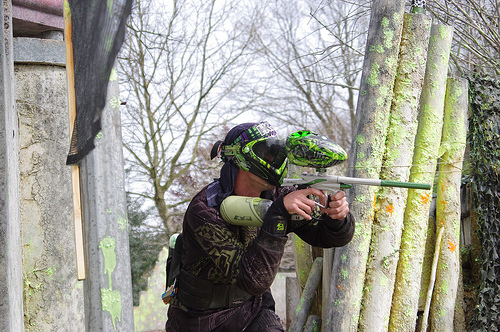

In [13]:
import random

choices = [i for i in range(9000)]
index = random.choice(choices)
print(index)
img_hash = test_ds[index][-1]["id"]
image_name = os.path.join("ParlAI/images/test_images", img_hash+".jpg")

trait_index = [1, 35, 40, 78, 168] #random.choice([i for i in range(216)]) 
# print(f"Trait Index: {trait_index}") # 168, 35

for i in trait_index:
    personality, cap = inference(index, i)  
    print(f"Generated Caption for Personality: {personality} is :- {cap}\n")
# print(f"Ground Truth Caption for Personality: {g_personality} is:- {ground_truths}")

Image.open(f"../{image_name}")

Generated Caption for Personality: Charming is :-  i ' d love to ride this .

Generated Caption for Personality: Happy is :-  i ' m so excited to see this ! i ' d love to go to

Generated Caption for Personality: Reflective is :-  i wish i had a kid like that .

Generated Caption for Personality: Businesslike is :-  i ' d love to go to a bike like this .



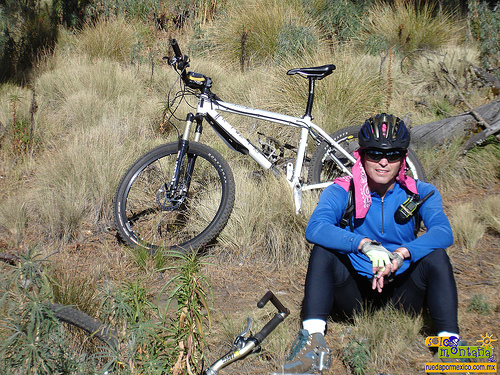

In [49]:
choices = [i for i in range(9000)]
index =  7302 #random.choice(choices)

img_hash = test_ds[index][-1]["id"]
image_name = os.path.join("ParlAI/images/test_images", img_hash+".jpg")

trait_index = [9, 35, 60, 88] #random.choice([i for i in range(216)]) 
# print(f"Trait Index: {trait_index}") # 168, 35

for i in trait_index:
    personality, cap = inference(index, i)  
    print(f"Generated Caption for Personality: {personality} is :- {cap}\n")
# print(f"Ground Truth Caption for Personality: {g_personality} is:- {ground_truths}")

Image.open(f"../{image_name}")

Generated Caption for Personality: Humorous is :-  i don ' t like that , i ' d like to go !

Generated Caption for Personality: Rigid is :-  i don ' t like this picture .

Generated Caption for Personality: Warm is :-  i would love to see this group of .

Generated Caption for Personality: Fawning (Flattering, Deferential) is :-  what a beautiful group of people .



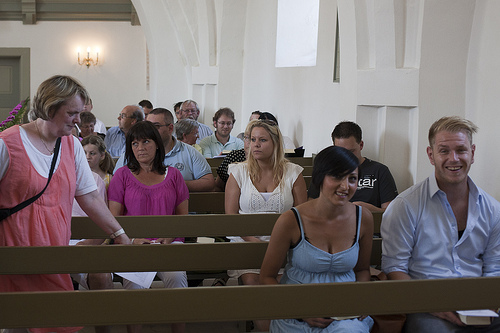

In [59]:
choices = [i for i in range(9000)]
index =  3590 #random.choice(choices)

img_hash = test_ds[index][-1]["id"]
image_name = os.path.join("ParlAI/images/test_images", img_hash+".jpg")

trait_index = [38, 201, 78, 160] #random.choice([i for i in range(216)]) 
# print(f"Trait Index: {trait_index}") # 168, 35

for i in trait_index:
    personality, cap = inference(index, i)  
    print(f"Generated Caption for Personality: {personality} is :- {cap}\n")
# print(f"Ground Truth Caption for Personality: {g_personality} is:- {ground_truths}")

Image.open(f"../{image_name}")

5792
Generated Caption for Personality: Happy is :-  i would love to go to this city !

Generated Caption for Personality: Resentful is :-  i don ' t like this city .

Generated Caption for Personality: Warm is :-  what a beautiful view , i would love to be here .

Generated Caption for Personality: Crazy is :-  i can ' t wait to see this city ! i ' d love to go



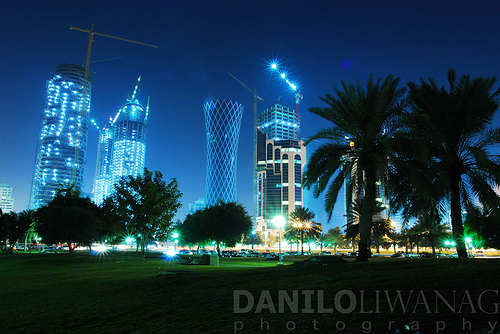

In [60]:
choices = [i for i in range(9000)]
index = 5792 # random.choice(choices)
print(index)
img_hash = test_ds[index][-1]["id"]
image_name = os.path.join("ParlAI/images/test_images", img_hash+".jpg")

trait_index = [35, 199, 78, 141] #random.choice([i for i in range(216)]) 
# print(f"Trait Index: {trait_index}") # 168, 35

for i in trait_index:
    personality, cap = inference(index, i)  
    print(f"Generated Caption for Personality: {personality} is :- {cap}\n")
# print(f"Ground Truth Caption for Personality: {g_personality} is:- {ground_truths}")

Image.open(f"../{image_name}")

In [7]:
import random
choices = [i for i in range(9000)]
index =  random.choice(choices)
print(index)

img_hash = test_ds[index][-1]["id"]
image_name = os.path.join("ParlAI/images/test_images", img_hash+".jpg")

trait_index = random.choice([i for i in range(216)]) 
print(f"Trait index: {trait_index}") # 35, 78
ofc_feats =  test_ds[index][0].to(device)
oatt_feats = test_ds[index][1].unsqueeze(0).to(device)
dcap = test_ds[index][2]
dcap = torch.from_numpy(np.int32(dcap)).to(device).unsqueeze(0)
attention_mask =  torch.ones(1, 80 // vals.beam_size)
# traits = torch.from_numpy(np.int32(test_ds[index][6])).to(device).unsqueeze(0)
traits = torch.nn.functional.one_hot(torch.arange(0, 217), num_classes=217)[trait_index].unsqueeze(0).to(device)

pred, _= model._sample_beam(ofc_feats, oatt_feats, dcap, attention_mask, personality=traits,  opt={"beam_size":vals.beam_size, 
                                                                                                  "temperature": 1.6})

pred = pred.detach().cpu().numpy().tolist()

ground_truths = []
for i in range(len(data)):
    if data[i]["id"] == img_hash:
        g_cap = data[i]["sentence"]
        
for i in g_cap:        
    ground_truths.append(" ".join(i))
        
ids = traits.detach().cpu().numpy()
personality_index = np.where(ids==1)[1][0]
personality = p2p["pix_to_personality"][str(personality_index)]
g_personality = test_ds[index][-1]["personality"]

cap = ""
for i in pred[0]:
    if i != 0:
        cap = cap + " " + vocab[i]
        
# print(f"Generated Caption for Personality: {personality} is :- {cap}\n")
print(f"Ground Truth Caption for Personality: {g_personality} is:- {ground_truths}")

Image.open(f"../{image_name}")

7581
Trait index: 9


NameError: name 'model' is not defined

In [20]:
f = torch.randn(128, 5, 16, 2048)

In [25]:
f.numel() // f.size(0) // 2048

80

In [ ]:
python densetrain3m.py --id "densepembed2_added" \
    --caption_model densepembed \
    --decoder_type LSTM \
    --mean_feats 1 \
    --ctx_drop 1 \
    --label_smoothing 0 \
    --input_json data/personalised_captions/training_ids.json \
    --metadata_json data/personalised_captions/i2w_personality_mapping.json \
    --input_label_h5 data/personalised_cap_labels/training_labels.npy \
    --input_label_start_idx data/personalised_cap_labels/training_start_ix.npy \
    --input_label_end_idx data/personalised_cap_labels/training_end_ix.npy \
    --input_fc_dir   data/yfcc_images/resnext101_32x48d_wsl \
    --input_att_dir  data/yfcc_images/resnext101_32x48d_wsl_spatial_att \
    --perss_onehot_h5  data/personalities_onehot/training.npy \
    --densecap_dir data/dense_captions/training.npy \
    --cached_tokens  cider_words/person-train-idxs \
    --start_from log_added_new1/log_"densepembed2_added" \
    --seq_per_img 1 \
    --batch_size 128 \
    --beam_size 1 \
    --learning_rate 2e-4 \
    --num_layers 2 \
    --input_encoding_size 1024 \
    --rnn_size 2048 \
    --att_hid_size 512 \
    --learning_rate_decay_start 0 \
    --scheduled_sampling_start 0 \
    --checkpoint_path log_added_new1/log_"densepembed2_added" \
    --language_eval 0 \
    --val_images_use -1 \
    --max_epochs 15 \
    --scheduled_sampling_increase_every 2 \
    --scheduled_sampling_max_prob 0.5 \
    --learning_rate_decay_every 2 \
    --self_critical_after 15 

In [ ]:
python  denseeval3m.py --id "densepembed2_added" \
    --dump_images 0 \
    --num_images -1 \
    --split test \
    --input_json data/personcap_added1.json \
    --input_label_h5 data/personcap_added1_label.h5 \
    --input_fc_dir   data/yfcc_images/resnext101_32x48d_wsl \
    --input_att_dir   data/yfcc_images/resnext101_32x48d_wsl_spatial_att \
    --perss_onehot_h5  data/person_onehot_added1.h5 \
    --batch_size 1024 \
    --seq_per_img  5 \
    --beam_size 4 \
    --language_eval 1 \
    --infos_path data/infos_"densepembed2_added"-best.pkl \
    --model log_added_new1/log_"densepembed2_added"/model-best.pth \
    --temperature 1.0